## Key Opinion Leaders. Top 100 ERC20 Holders by Tokens

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import log10

from config import PROJECT_ID, \
    ERC20_ANALYSIS_DATASET_NAME, ERC20_BALANCES_TABLE_NAME, ERC20_TOKEN_METADATA_TABLE_NAME, \
    ERC20_TOP_DISTRIBUTION_TABLE_NAME
from src.utils_bigquery import drop_table, create_table, get_df
from src.utils_charts import heatmap_from_df

DROP_TABLES = True
CREATE_TABLES = True

### Distribution Rule

<table style="text-align: center">
    <thead style="text-align: center">
        <tr>
            <th rowspan=2></th>
            <th colspan=3>Grade</th>
        </tr>
        <tr>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> Top 100 ERC20 Holders by Tokens </td>
            <td> - </td>
            <td> - </td>
            <td> only hear </td>
        </tr>
    </tbody>
</table>

In [2]:
number_top_address = 100

### Create Distribution Table

In [3]:
query_1 = f'''
    SELECT
        address,
        3 AS grade,
        token_address,
        eth_balance,
        rank
    FROM (
        SELECT
            address,
            token_address,
            eth_balance,
            ROW_NUMBER() OVER (PARTITION BY token_address ORDER BY balance DESC) AS rank
        FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_BALANCES_TABLE_NAME}`
        WHERE balance > 0
        )
    WHERE rank <= {number_top_address}
'''

if DROP_TABLES:
    drop_table(ERC20_TOP_DISTRIBUTION_TABLE_NAME, dataset_name=ERC20_ANALYSIS_DATASET_NAME)

if CREATE_TABLES:
    create_table(query_1, ERC20_TOP_DISTRIBUTION_TABLE_NAME, dataset_name=ERC20_ANALYSIS_DATASET_NAME)

Table erc20_analysis:erc20_top_distribution has been deleted.
Table erc20_analysis:erc20_top_distribution has been created and filled 4,700 rows.


### Distribution of Key Opinion Leaders by Tokens

In [4]:
query_2 = f'''
    SELECT
        ANY_VALUE(token_names) AS token_names,
        count(address) AS address_count
    FROM (
        SELECT
            address,
            ARRAY_AGG(DISTINCT token_name) as token_names
        FROM (
            SELECT
                address,
                token_name
            FROM (
                SELECT
                    address,
                    token_address
                FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_TOP_DISTRIBUTION_TABLE_NAME}`)
            LEFT JOIN (
                SELECT
                    index as token_name,
                    address as token_address
                FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_TOKEN_METADATA_TABLE_NAME}`
            )
            USING (token_address)
        )
        GROUP BY address)
    GROUP BY TO_JSON_STRING(token_names)
'''

top_holders_heatmap_distribution_df = get_df(query_2)

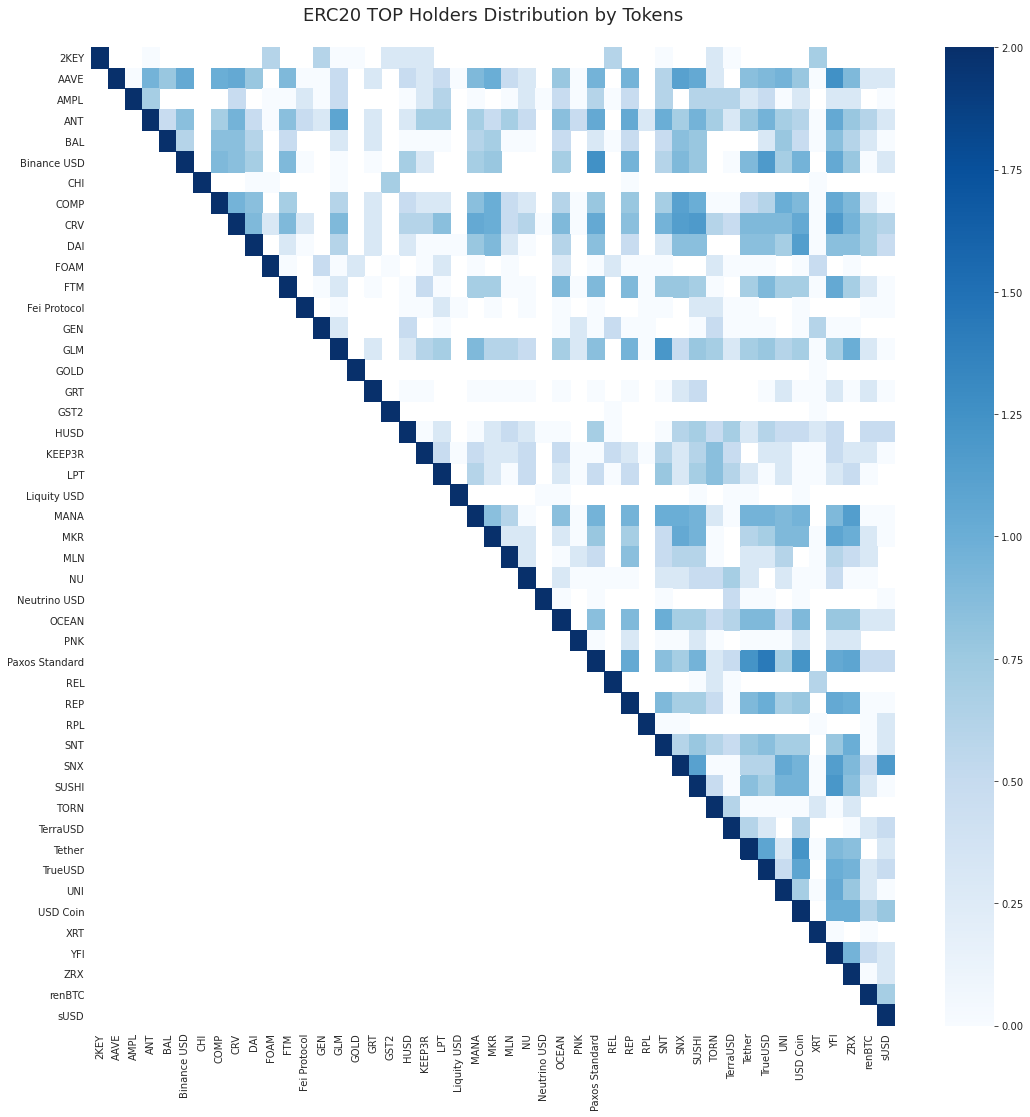

In [5]:
heatmap_from_df(top_holders_heatmap_distribution_df,
                title='ERC20 TOP Holders Distribution by Tokens\n',
                fig_size=18)

### Distribution of Key Opinion Leaders by Number of Tokens

In [6]:
query_2 = f'''
    SELECT
        token_number,
        count(DISTINCT address) as number_of_addresses
    FROM (
        SELECT
            address,
            count(DISTINCT token_name) as token_number
        FROM (
            SELECT
                address,
                token_name
            FROM (
                SELECT
                    address,
                    token_address
                FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_TOP_DISTRIBUTION_TABLE_NAME}`)
            LEFT JOIN (
                SELECT
                    index as token_name,
                    address as token_address
                FROM `{PROJECT_ID}.{ERC20_ANALYSIS_DATASET_NAME}.{ERC20_TOKEN_METADATA_TABLE_NAME}`
            )
            USING (token_address)
        )
        GROUP BY address)
    GROUP BY token_number
'''

top_holders_distribution_by_token_number_df = get_df(query_2)

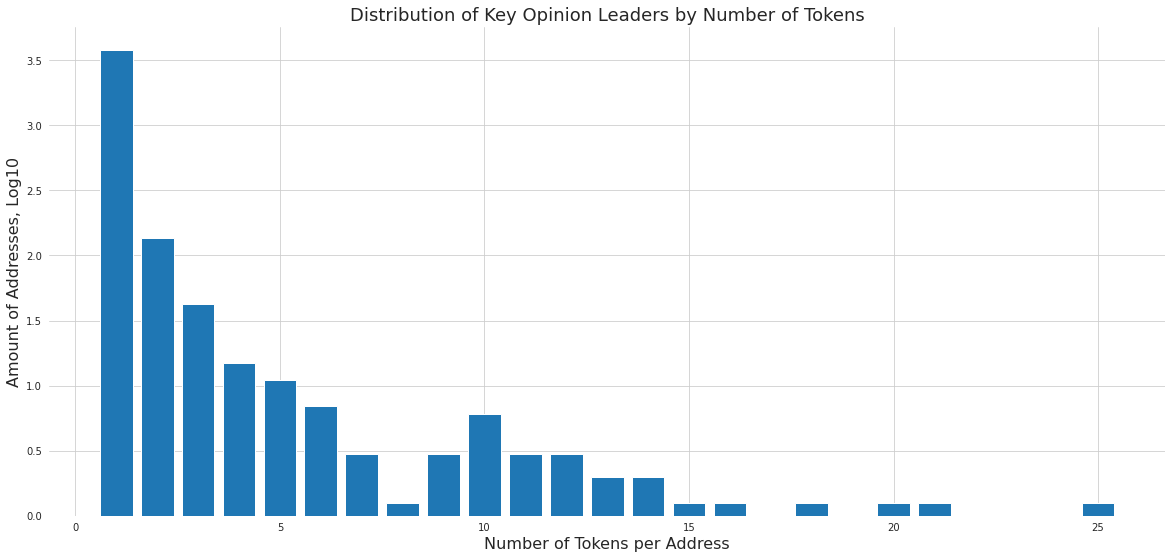

In [7]:
mpl.rcParams['figure.figsize'] = (20.0, 9.0)
fig, ax = plt.subplots()
plt.bar(top_holders_distribution_by_token_number_df.token_number,
        top_holders_distribution_by_token_number_df.number_of_addresses.map(lambda x: log10(x) if x > 1 else 0.1))

ax.set_title('Distribution of Key Opinion Leaders by Number of Tokens', fontsize=18)
ax.set_ylabel('Amount of Addresses, Log10', fontsize=16)
ax.set_xlabel('Number of Tokens per Address', fontsize=16)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)